# 利用pytorch建立MLP進行MNIST分類模型(介紹Cross Entropy loss的運作)

Pytorch訓練流程<br>

0. 是否使用CUDA <br>
1. 讀資料(dataset和dataloader)<br> 
2. 模型宣告 <br> 
3. 宣告/建立loss function<br>
4. 建立模型的參數最佳化器 <br>
5. 模型開始訓練 <br>

**<font color = blue size=4>  0.是否使用CUDA </font>**<br>

<br>宣告一個device決定CPU或是GPU運算</br>

In [1]:
import torch
use_cuda=1
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


上面是我們自己說要下到cuda裡面，但實際上沒有cuda就慘了

In [2]:
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)
print(type(device))
print(torch.cuda.is_available())

cuda
<class 'torch.device'>
True


**<font color = blue size=4>1. 讀資料(dataset和dataloader)</font>**<br><br>
這邊是利用torchvision的模組將MNIST dataset帶入<br>
並且利用torch.utils.data.DataLoader進行dataloader<br>
詳細內容前面課程已經提過了，因此帶過<br>

C:\Users\user\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([10, 1, 28, 28])
torch.Size([10, 784])


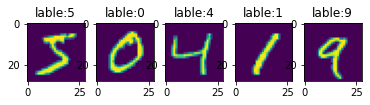

In [3]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
transform = transforms.ToTensor()
dataset_MNIST_tensor = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
mnistdata_loader = torch.utils.data.DataLoader(dataset_MNIST_tensor, batch_size=10)
for data in mnistdata_loader:
    image, label = data
    print(image.shape)
    print(image.view(-1,28*28).shape)
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(image[i,0,:,:])
        plt.title('lable:{}'.format(label[i]))
    plt.show()
    break

----------------------
**<font color = blue size=4> 2. 模型宣告</font>**<br>

<br>這邊在宣告你要用什麼神經網路，自己兜得或是開源模型都可以<br>
**1. Single layer perceptron (SLP)** <br>
<br>這邊我們用一個一層Hidden layer </br>
<br>因為全連接層圖片須拉成1D array，所以28x28的手寫圖片需要轉換成一個28x28=754的一維陣列</br>
<br>所以神經網路的結構為</br>
Input layer (node數為754) → Hidden layer (node數設定為512) → Output layer (node數為10)</br>

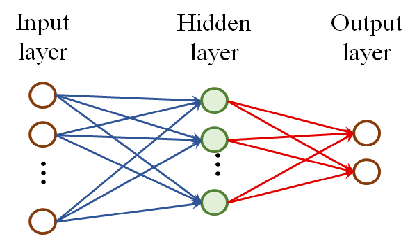

**2. MLP** <br>
<br>這邊我們用一個三層Hidden layer </br>
<br>因為全連接層圖片須拉成1D array，所以28x28的手寫圖片需要轉換成一個28x28=754的一維陣列</br>
<br>所以神經網路的結構為</br>
Input layer (node數為754) → Hidden layer (node數設定為512) → Hidden layer (node數設定為256) → Hidden layer (node數設定為128) → Output layer (node數為10)</br>

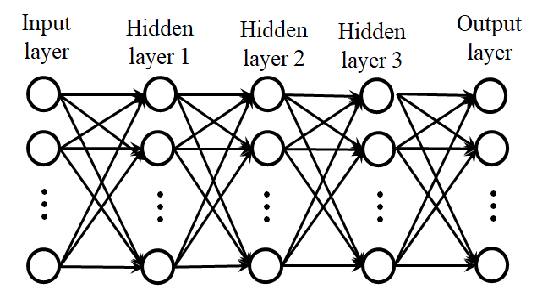





In [4]:
## 1. MLP
import torch.nn as nn
import torch.nn.functional as F
# define NN architecture
class SLP(nn.Module):
    def __init__(self, n_class):
        super(SLP,self).__init__()
        self.slp = torch.nn.Sequential(
            nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(128, n_class),
            )
    def forward(self,x):
        # flatten image input
        x = self.slp(x)
        return x
    
# define NN architecture
class MLP(nn.Module):
    def __init__(self, n_class):
        super(MLP,self).__init__()
        self.mlp = torch.nn.Sequential(
            nn.Linear(28*28, 96),
            torch.nn.ReLU(),
            nn.Linear(96, 64),
            torch.nn.ReLU(),
            nn.Linear(64, 32),
            torch.nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(32, n_class),
            )
    def forward(self,x):
        # flatten image input
        x = self.mlp(x)
        return x
    
# initialize the MLP
model_slp = SLP(n_class=10)
print(model_slp)
model_mlp = MLP(n_class=10)
print(model_mlp)

dummy_inpurt = torch.rand(1,1,28,28)
dummy_inpurt = dummy_inpurt.view(-1,28*28)
out=model_slp(dummy_inpurt)
torch.onnx.export(model_slp, dummy_inpurt, './slp.onnx', opset_version=11, example_outputs=out)
torch.onnx.export(model_mlp, dummy_inpurt, './mlp.onnx', opset_version=11, example_outputs=out)

SLP(
  (slp): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)
MLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=96, bias=True)
    (1): ReLU()
    (2): Linear(in_features=96, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Linear(in_features=32, out_features=10, bias=True)
  )
)


參數量:
**1. SLP** <br>
Input layer (node數為784) → Hidden layer (node數設定為128) → Output layer (node數為10)</br>
$784 \times 128+128 = 100,480$</br>
$ 128 \times 10+10 = 1,290 $</br>
總參數: 101,770</br>
FP32: 32 bits = 4 Byte</br>
$101,770 \times 4 \div 1024 = 397.5$KB</br>

**2. MLP** <br>
Input layer (node數為784) → Hidden layer (node數設定為96) → Hidden layer (node數設定為64) → Hidden layer (node數設定為32) → Output layer (node數為10)</br>
$784 \times 96+96 = 75,360$</br>
$96 \times 64+64 = 6,208$</br>
$64 \times 32+32 = 2,080$</br>
$32 \times 10+10 = 330$</br>
總參數: 83,978</br>
$83,978  \times 4 \div 1024 = 328.0$KB</br>


----------------------
**<font color = blue size=4> 步驟3.loss function宣告</font>**<br>
<br>宣告loss函數，模型預測的結果和ground truth整合計算差異用來更新模型</br>
<br>這邊提的是和ground truth整合計算差異所以泛屬於supervised learning</br>
<br>reference:https://pytorch.org/docs/stable/nn.html#loss-functions

<br>**這邊我們用到的是cross entropy作為loss function**
<br>torch.nn.CrossEntropyLoss = log_softmax → nll_loss 
<br>log_softmax: torch.nn.functional.log_softmax
<br>nll_loss: torch.nn.functional.nll_loss (negative log likelihood loss)

In [5]:
loss = torch.nn.CrossEntropyLoss()

import numpy as np
x = np.array([[3.0,2.0,1.0],[4.0,5.0,6.0]])
inputdata = torch.tensor(x, requires_grad=True)
target = np.array([0, 2])
target = torch.LongTensor(target)
output1 = loss(inputdata, target)
print('inputdata:{}'.format(inputdata))
print('target:{}'.format(target))
print('loss value by function (torch.nn.CrossEntropyLoss): {}'.format(output1))


from  torch.nn.functional import log_softmax,nll_loss, softmax

ls_x = log_softmax(inputdata,dim=1)
output2 = nll_loss(ls_x, target)
print('loss value by (log_softmax and nll_loss): {}'.format(output2))


inputdata:tensor([[3., 2., 1.],
        [4., 5., 6.]], dtype=torch.float64, requires_grad=True)
target:tensor([0, 2])
loss value by function (torch.nn.CrossEntropyLoss): 0.4076059644443804
loss value by (log_softmax and nll_loss): 0.4076059644443804


所以用程式算Cross entropy分別用這兩種方式計算
<br> 1. torch.nn.CrossEntropyLoss，結果為 0.4076059644443804
<br> 2. log_softmax → nll_loss，結果為 0.4076059644443804
<br>結果是一樣的

<br>**利用手算**:  
<br>$ x = \begin{bmatrix} 3 & 2 & 1 \\ 4 & 5 & 6 \\ \end{bmatrix} $
$, label = \begin{bmatrix} 0 \\ 2 \\ \end{bmatrix} $
<br>Onehot encoder for label:
<br>$ y(label) = \begin{bmatrix} 1 & 0 & 0 \\ 0 & 0 & 1 \\ \end{bmatrix} $

<br> softmax operator:
<br>$ p_i = softmax(x_i)= \frac{exp((x_i))}{\sum_{l=1}^L exp(x_i(l))}$

<br>$ p = \begin{bmatrix} p_1 \\ p_2 \\ \end{bmatrix} = \begin{bmatrix} 0.6652 & 0.2447 & 0.0900 \\ 0.0900 & 0.2447 & 0.6652 \\ \end{bmatrix}$

<br>$ log(p) = \begin{bmatrix} -0.4076 & -1.4076 & -2.4076 \\ -2.4076 & -1.4076 & -0.4076 \\ \end{bmatrix}$

$CE = -\sum_{i=1}^n \sum_{c=1}^L y_{i,c} * log(p_{i,c})$
<br>$ = -(1 \times -0.4076 + 0 \times -1.4076 + 0 \times-2.4076)  + (0 \times -2.4076 + 0 \times -1.4076 + 1 \times-0.4076) $
<br>$ = -(-0.4076 + -0.4076) $
<br>$ = 0.8152 $

<font color = red  size=4>**手算結果為0.8152怎麼跟程式 0.4076不一樣**</font>
<br><br> 我們看一下程式碼CrossEntropyLoss default參數
<br><br>   torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=-100, reduce=None, <font color = red> **reduction='mean'**</font>)
<br><br> 程式碼用平均後的結果，所以手算的結果0.8152除上2，$ 0.8152 \div{2} =0.4076$ 就跟程式 0.4076的一樣了
<br><br> 這個範例是兩筆資料，假設我們有一千筆資料，每一筆資料的CE loss都是0.4076，如果我們不用平均的方式處理，CE=407.6，這樣的loss值太大，我們很難好好更新模型參數，所以採用平均數的做法有點類似正規化，避免整體loss因為樣本數過多爆掉。


--------------------
**<font color = blue size=4> 步驟4. optimator宣告</font>**<br>

<br> 這個步驟是在看我們模型更新需要改用什麼樣的演算法
<br> 例如: SGD, Adagrad, RMSprop, Adam, LBFGS等。
<br>reference: https://pytorch.org/docs/stable/optim.html

In [6]:
import torch.optim as optim
# optimizer = optim.Adadelta(model.parameters(), lr=0.01)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer_slp = optim.SGD(model_slp.parameters(), lr=0.01, momentum=0.9, weight_decay=0.02)
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9, weight_decay=0.02)


--------------------
**<font color = blue size=4> 步驟5. 模型開始訓練</font>**<br>


In [7]:
import PIL.Image as Image
# transform = transforms.ToTensor()
transform = transforms.Compose([
            transforms.RandomRotation(degrees=(-30, 30), fill=(0,), resample=Image.BICUBIC, expand=False),
            transforms.ToTensor()
            ])

dataset_train = datasets.MNIST('./dataset', train=True, download=False, transform=transform)
dataset_test = datasets.MNIST('./dataset', train=False, download=False, transform= transforms.ToTensor())
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=256)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=256)

model_slp = SLP(n_class=10).to(device)
model_mlp = MLP(n_class=10).to(device)

loss = torch.nn.CrossEntropyLoss().to(device)

optimizer_slp = optim.SGD(model_slp.parameters(), lr=0.01, momentum=0.9)
optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.9)

plt_loss_mlp,plt_loss_slp=[],[]
plt_acc_mlp,plt_acc_slp=[],[]
for epoch in range(10):
    # train
    model_slp.train()
    model_mlp.train()
    
    for batch_idx, (data, target) in enumerate(dataloader_train):
        data, target = data.to(device), target.to(device)
        data = data.view(-1,28*28)

        # MLP
        output_mlp = model_mlp(data) # batch * 10
        loss_mlp = loss(output_mlp, target) # batch * n_class, target: batch    
        model_mlp.zero_grad()
        loss_mlp.backward()
        optimizer_mlp.step()
        
        # slp
        output_slp = model_slp(data)
        loss_slp = loss(output_slp, target)
        model_slp.zero_grad()
        loss_slp.backward()
        optimizer_slp.step()
        
        if batch_idx % 50 ==0 :
            print('MLP Train Epoch:{} [{:.1f}%]\tLoss: {:.6f}'.format(
                epoch, 
                100. * batch_idx / len(dataloader_train), 
                loss_mlp.item())
                 )
            
            print('SLP Train Epoch:{} [{:.1f}%]\tLoss: {:.6f}'.format(
                epoch, 
                100. * batch_idx / len(dataloader_train), 
                loss_slp.item())
                 )
                   
    # Test
    model_slp.eval()
    model_mlp.eval()
    test_loss_mlp,  test_loss_slp= 0, 0
    correct_mlp, correct_slp = 0, 0
    with torch.no_grad():
        for data, target in dataloader_test:
            data, target = data.to(device), target.to(device)
            data = data.view(-1,28*28)

             # MLP
            output_mlp = model_mlp(data)
            test_loss_mlp += loss(output_mlp, target)
            pred_mlp = output_mlp.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_mlp += pred_mlp.eq(target.view_as(pred_mlp)).sum().item()
            
            # SLP
            output_slp = model_slp(data)
            test_loss_slp += loss(output_slp, target)
            pred_slp = output_slp.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct_slp += pred_slp.eq(target.view_as(pred_slp)).sum().item()
            
    
    test_loss_mlp /= len(dataloader_test.dataset)
    test_loss_slp /= len(dataloader_test.dataset)
    print('MLP Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss_mlp, correct_mlp, len(dataloader_test.dataset),
        100. * correct_mlp / len(dataloader_test.dataset)))
    print('SLP Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss_slp, correct_slp, len(dataloader_test.dataset),
        100. * correct_slp / len(dataloader_test.dataset)))
    plt_loss_mlp.append(test_loss_mlp.cpu().item())    
    plt_loss_slp.append(test_loss_slp.cpu().item())
    plt_acc_mlp.append(correct_mlp / len(dataloader_test.dataset))    
    plt_acc_slp.append(correct_slp / len(dataloader_test.dataset))

C:\Users\user\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


MLP Train Epoch:0 [0.0%]	Loss: 2.316077
SLP Train Epoch:0 [0.0%]	Loss: 2.303830
MLP Train Epoch:0 [21.3%]	Loss: 2.288734
SLP Train Epoch:0 [21.3%]	Loss: 1.613712
MLP Train Epoch:0 [42.6%]	Loss: 2.236029
SLP Train Epoch:0 [42.6%]	Loss: 0.860698
MLP Train Epoch:0 [63.8%]	Loss: 2.001664
SLP Train Epoch:0 [63.8%]	Loss: 0.825080
MLP Train Epoch:0 [85.1%]	Loss: 1.439460
SLP Train Epoch:0 [85.1%]	Loss: 0.684860
MLP Test set: Average loss: 0.0038, Accuracy: 6975/10000 (70%)
SLP Test set: Average loss: 0.0018, Accuracy: 8766/10000 (88%)

MLP Train Epoch:1 [0.0%]	Loss: 1.109405
SLP Train Epoch:1 [0.0%]	Loss: 0.645540
MLP Train Epoch:1 [21.3%]	Loss: 1.032491
SLP Train Epoch:1 [21.3%]	Loss: 0.715057
MLP Train Epoch:1 [42.6%]	Loss: 0.816450
SLP Train Epoch:1 [42.6%]	Loss: 0.516073
MLP Train Epoch:1 [63.8%]	Loss: 0.802248
SLP Train Epoch:1 [63.8%]	Loss: 0.614063
MLP Train Epoch:1 [85.1%]	Loss: 0.670067
SLP Train Epoch:1 [85.1%]	Loss: 0.481096
MLP Test set: Average loss: 0.0018, Accuracy: 8565/10000 

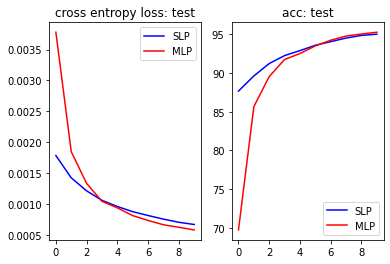

In [8]:

plt.figure
plt.subplot(1,2,1)
plt.plot(plt_loss_slp,'b')
plt.plot(plt_loss_mlp,'r')
plt.legend(['SLP','MLP'])
plt.title('cross entropy loss: test')

plt.subplot(1,2,2)
plt.plot(np.array(plt_acc_slp)*100,'b')
plt.plot(np.array(plt_acc_mlp)*100,'r')
plt.legend(['SLP','MLP'])
plt.title('acc: test')
plt.show()

### 討論model.eval()和onnxruntime執行結果

In [14]:
dummy_input = torch.randn(1, 784)

model_mlp.train()
model_mlp = model_mlp.to(torch.device("cpu"))
torch.onnx.export(model_mlp, dummy_input, "mlp_trained.onnx")
with torch.no_grad():
    output_ft = model_mlp(dummy_input)
print('output:{}'.format(output_ft))


model_mlp.eval()
with torch.no_grad():
    output_ft = model_mlp(dummy_input)
print('output:{}'.format(output_ft))

import onnxruntime as ort
onnxmodel_path="mlp_trained.onnx"
session = ort.InferenceSession(onnxmodel_path, None)
input_name = session.get_inputs()[0].name
np_input = dummy_input.numpy()
outputs = session.run([], {input_name: np_input})[0] 
print("Output:{}".format(outputs))

output:tensor([[-3.8213,  2.1149,  5.8821, -0.9590,  1.6864, -4.0038, -0.4221,  3.0911,
         -0.4675, -1.8946]])
output:tensor([[-1.6047, -1.5934,  7.4638, -1.8738,  3.4895, -6.0941,  0.1611,  6.2837,
         -5.0843,  0.1152]])
Output:[[-1.6046803  -1.5933933   7.463822   -1.873833    3.4894602  -6.0940704
   0.16111791  6.2836714  -5.0843005   0.11523659]]
